<a href="https://colab.research.google.com/github/romera-rocio/Titanic_Rocio_Romera/blob/main/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importacion de Data set

In [3]:
!pip install kaggle


In [4]:
from google.colab import files
files.upload()   # elegís kaggle.json desde tu PC


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rociobelenromerasily","key":"208666ac7f2897d87da9c755267e4620"}'}

In [7]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c titanic
!unzip titanic.zip


titanic.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


## Importacion de librerias



1.   Preprosesamiento y Graficos : Pandas , Numpy, Matplotlib y Seaborn

2.   PostProcesamiento: Scikit-learn( algoritmos de aprendizaje automático ) y SciPy ( Test estadisticos )





In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import chi2_contingency


## Exploracion de Data Set

Train contiene la variable objetivo Survived.
Test no incluye Survived, por lo que se usa solo para predicción.
gender_submission es un archivo de ejemplo proporcionado por Kaggle.

In [9]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
gender_submission = pd.read_csv("gender_submission.csv")

train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Analisis Estadistico Descriptivo

In [10]:
print("Información general del dataset:")
train.info()

print("\nValores faltantes por columna:")
print(train.isna().sum())

train.describe()


Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

Valores faltantes por columna:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare    

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
train.describe()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Análisis Exploratorio Visual (EDA visual)

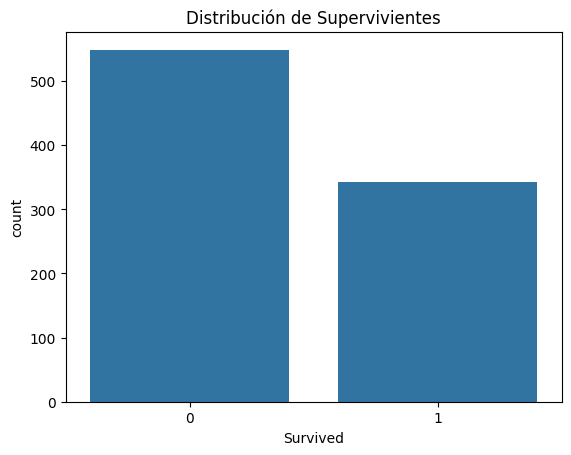

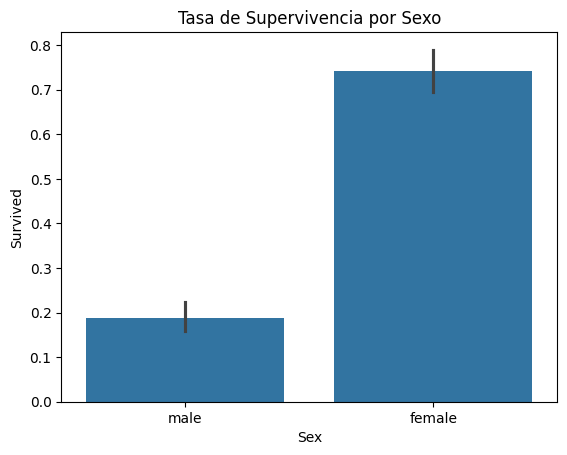

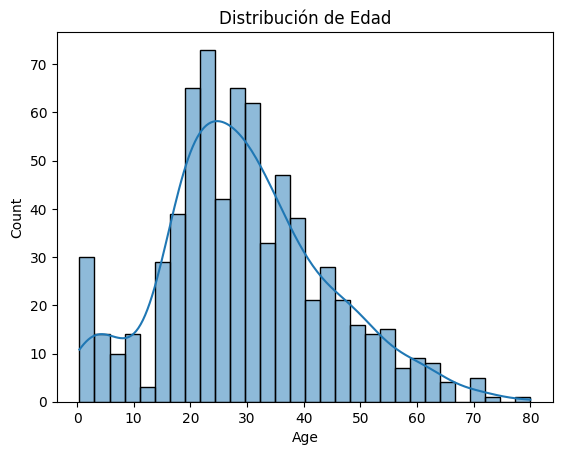

In [15]:
sns.countplot(data=train, x="Survived")
plt.title("Distribución de Supervivientes")
plt.show()
sns.barplot(data=train, x="Sex", y="Survived")
plt.title("Tasa de Supervivencia por Sexo")
plt.show()
sns.histplot(data=train, x="Age", bins=30, kde=True)
plt.title("Distribución de Edad")
plt.show()


## Conclusiones del Análisis Exploratorio

- El dataset contiene **891 registros y 12 variables**.
- La variable objetivo **Survived** no presenta valores faltantes.
- **Age** tiene ~20% de valores faltantes → requiere imputación (preferible mediana).
- **Cabin** posee ~77% de faltantes → descartarla o convertir en indicador binario.
- **Embarked** tiene solo 2 valores faltantes → imputación por moda.
- **Survived** está desbalanceada (≈62% no, 38% sí).
- La edad es asimétrica, concentrada entre 20–30 años.
- La supervivencia por **Sex** es muy desigual (≈74% mujeres, 19% hombres).
- **Pclass** se concentra en clase 3 y está asociada a la supervivencia.
- **SibSp** y **Parch** son bajos → útil derivar *FamilySize*.
- **Fare** tiene alta varianza y fuerte asimetría → recomendable log-transform.
- Existen relaciones no lineales entre sexo, clase y supervivencia → modelos de árboles recomendados.
- Variables categóricas como **Sex** y **Embarked** requieren codificación adecuada.
- La variable objetivo está correlacionada con características sociodemográficas, lo que confirma la predictibilidad del problema.


## Hipotesis

# Hipótesis del análisis (versión H0/H1)

**H1. Sexo**
- H0: El sexo del pasajero no afecta la probabilidad de supervivencia.  
- H1: El sexo del pasajero sí afecta la probabilidad de supervivencia.

**H2. Clase (Pclass)**
- H0: La clase socioeconómica no influye en la supervivencia.  
- H1: La clase socioeconómica sí influye en la supervivencia.

**H3. Edad (Age)**
- H0: La edad del pasajero no está asociada con la supervivencia.  
- H1: La edad del pasajero sí está asociada con la supervivencia.

**H4. Tarifa (Fare)**
- H0: La tarifa pagada no afecta la probabilidad de supervivencia.  
- H1: La tarifa pagada sí afecta la probabilidad de supervivencia.

**H5. Puerto de embarque (Embarked)**
- H0: El puerto de embarque no influye en la supervivencia.  
- H1: El puerto de embarque sí influye en la supervivencia.

**H6. Tamaño familiar (FamilySize)**
- H0: El tamaño familiar no está asociado con la supervivencia.  
- H1: El tamaño familiar sí está asociado con la supervivencia.

**H7. Registro de cabina (Cabin / Deck)**
- H0: Tener registro de cabina no afecta la probabilidad de supervivencia.  
- H1: Tener registro de cabina sí afecta la probabilidad de supervivencia.

**H8. Título social (Title)**
- H0: El título social del pasajero no aporta información relevante para predecir la supervivencia.  
- H1: El título social del pasajero sí aporta información relevante.

**H9. Interacción sexo × clase**
- H0: La interacción entre sexo y clase no mejora la explicación de la supervivencia.  
- H1: La interacción entre sexo y clase sí mejora la explicación de la supervivencia.

**H10. Patrón del ticket (Ticket prefix)**
- H0: Los prefijos del ticket no están asociados a la supervivencia.  
- H1: Los prefijos del ticket sí están asociados a la supervivencia.

**H11. Interacción Fare × Pclass**
- H0: La combinación de tarifa y clase no afecta la probabilidad de supervivencia.  
- H1: La combinación de tarifa y clase sí afecta la probabilidad de supervivencia.

**H12. Modelos no lineales**
- H0: Los modelos no lineales no mejoran el rendimiento respecto a modelos lineales.  
- H1: Los modelos no lineales sí mejoran el rendimiento respecto a modelos lineales.

**H13. Estandarización**
- H0: Escalar las variables numéricas no mejora el rendimiento de los modelos sensibles a escala.  
- H1: Escalar las variables numéricas sí mejora el rendimiento de los modelos sensibles a escala.

**H14. Imputación avanzada de edad**
- H0: La imputación avanzada (RF/KNN) no mejora la predicción respecto a imputación simple.  
- H1: La imputación avanzada sí mejora la predicción.

**H15. Features derivadas**
- H0: Las variables creadas (FamilySize, IsAlone, Title, Deck) no incrementan el rendimiento de los modelos.  
- H1: Las variables creadas sí incrementan el rendimiento de los modelos.
